# Citi Bike NYC Ridetime Analysis: Exploring patterns and building prediction

## Introduction

## Data Sources

- **Citi Bike Trip Data**: Publicly available from official Citi Bike system data portal: https://citibikenyc.com/system-data. Extracted data covers period from 2024-01-01 to 2025-06-01.
- **Weather Data**: Historical data for NYC was obtained from https://openweathermap.org/history-bulk. This dataset was purchased to supplement trips data and covers period from 2024-01-01 to 2025-06-01.



## Data Loading & Cleaning

In [1]:
import os
from dotenv import load_dotenv

from google.cloud import bigquery

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

True

In [3]:
client = bigquery.Client()

bq_project_id = os.getenv('GCP_PROJECT_ID')
bq_dataset_name = os.getenv('BQ_DATASET')
bq_trips_table_name = os.getenv('BQ_TABLE_TRIPS')
bq_weather_table_name = os.getenv('BQ_TABLE_WEATHER')

table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_trips_table_name}'
cleaned_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_trips_table_name}_cleaned'
weather_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_weather_table_name}'
cleaned_weather_table_ref = f'{bq_project_id}.{bq_dataset_name}.{bq_weather_table_name}_cleaned'

Fisrt step is to understand how data looks like, what columns and types it has.

In [4]:
query = f"""
    SELECT *
    FROM `{table_ref}`
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F9CCEBF8D94C0A16,classic_bike,2024-06-12 17:51:15.505000+00:00,2024-06-12 18:02:43.774000+00:00,58 St & Pier 4,3220.01,67 St & Erik Pl,2733.03,40.646475,-74.026081,40.633385,-74.016562,member
1,8AA50A79D71A04B8,classic_bike,2024-06-12 17:24:07.743000+00:00,2024-06-12 17:53:20.167000+00:00,Prospect Ave & Vanderbilt St,3426.02,67 St & Erik Pl,2733.03,40.653368,-73.976291,40.633385,-74.016562,member
2,4D68C6542D0D10BB,classic_bike,2024-06-12 16:29:21.789000+00:00,2024-06-12 17:01:18.472000+00:00,Underhill Ave & Pacific St,4231.04,67 St & Erik Pl,2733.03,40.680484,-73.964680,40.633385,-74.016562,member
3,0FFB2DFEFA82A1E7,classic_bike,2024-06-12 12:08:36.965000+00:00,2024-06-12 12:20:47.097000+00:00,7 Ave & 41 St,3192.05,67 St & Erik Pl,2733.03,40.647379,-74.000911,40.633385,-74.016562,member
4,C93D8F20267F9638,classic_bike,2024-06-12 06:56:00.436000+00:00,2024-06-12 07:12:01.481000+00:00,17 St & 5 Ave,3699.07,5 Ave & 67 St,2782.02,40.663493,-73.991007,40.635679,-74.020005,member


In [5]:
print(df.columns.values)

['ride_id' 'rideable_type' 'started_at' 'ended_at' 'start_station_name'
 'start_station_id' 'end_station_name' 'end_station_id' 'start_lat'
 'start_lng' 'end_lat' 'end_lng' 'member_casual']


In [6]:
df.dtypes

ride_id                            object
rideable_type                      object
started_at            datetime64[us, UTC]
ended_at              datetime64[us, UTC]
start_station_name                 object
start_station_id                   object
end_station_name                   object
end_station_id                     object
start_lat                         float64
start_lng                         float64
end_lat                           float64
end_lng                           float64
member_casual                      object
dtype: object

Next is dealing with missing values to ensure accurate analysis.

In [7]:
query = f"""
    SELECT 
        COUNT(*) - COUNT(ride_id) as ride_id_null,
        COUNT(*) - COUNT(rideable_type) as rideable_type_null,
        COUNT(*) - COUNT(started_at) as started_at_null,
        COUNT(*) - COUNT(ended_at) as ended_at_null,
        COUNT(*) - COUNT(start_station_name) as start_station_name_null,
        COUNT(*) - COUNT(start_station_id) as start_station_idnull,
        COUNT(*) - COUNT(end_station_name) as end_station_name_null,
        COUNT(*) - COUNT(end_station_id) as end_station_id_null,
        COUNT(*) - COUNT(start_lat) as start_lat_null,
        COUNT(*) - COUNT(start_lng) as start_lng_null,
        COUNT(*) - COUNT(end_lat) as end_lat_null,
        COUNT(*) - COUNT(end_lng) as end_lng_null,
        COUNT(*) - COUNT(member_casual) as member_casual_null
    FROM `{table_ref}`
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id_null,rideable_type_null,started_at_null,ended_at_null,start_station_name_null,start_station_idnull,end_station_name_null,end_station_id_null,start_lat_null,start_lng_null,end_lat_null,end_lng_null,member_casual_null
0,0,0,0,0,35253,0,152745,0,0,0,12784,12784,0


Work goal is predicting ride time on a start data, so *start_station_name* can be important feature. As for *end_station_name*, *end_lat* and *end_lng* they will not be used and can be not considered. 
<br> 
<br>
Lets check for any *start_station_name* missing values pattern.

In [8]:
query = f"""
    SELECT *
    FROM `{table_ref}`
    WHERE start_station_name IS NULL
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,49BDE0642F7E38BC,electric_bike,2024-08-05 09:42:16.884000+00:00,2024-08-05 09:49:14.244000+00:00,None,nan,55 St & 5 Ave,3050.03,40.64,-74.01,40.642408,-74.013318,member
1,50E7368DB8165036,electric_bike,2024-08-05 17:46:56.976000+00:00,2024-08-05 17:49:12.491000+00:00,None,nan,Parkside Ave & Parade Pl,3376.04,40.65,-73.97,40.653200,-73.966390,member
2,65A6D4004D9EDDE5,electric_bike,2024-08-05 18:39:38.364000+00:00,2024-08-05 18:45:13.619000+00:00,None,nan,Clarkson Ave & Utica Ave,3486.02,40.67,-73.93,40.656660,-73.931090,casual
3,B50A8CE2E0D2CC0E,electric_bike,2024-08-05 20:42:57.586000+00:00,2024-08-05 21:07:57.293000+00:00,None,nan,Lincoln Rd & Ocean Ave,3633.08,40.67,-73.97,40.660500,-73.962600,member
4,A3DDF0A5F964D02A,electric_bike,2024-08-05 22:25:59.593000+00:00,2024-08-06 01:48:49.353000+00:00,None,nan,Sterling St & Nostrand Ave,3657.06,40.67,-73.96,40.663180,-73.950760,casual


For null *start_station_name* feature *start_station_id* has string value 'nan'. Is it case for all rows?

In [9]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM `{table_ref}`
    WHERE start_station_name IS NULL AND start_station_id != 'nan'
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,cnt
0,0


Any rows where *start_station_id* is 'nan' but *start_station_name* is not null?

In [10]:
query = f"""
    SELECT COUNT(*) as cnt
    FROM `{table_ref}`
    WHERE start_station_name IS NOT NULL AND start_station_id = 'nan'
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,cnt
0,0


As it is same for all missing values and 30k is relatively small to 60m, entries with null *start_station_name* can be safely removed to ensure accuracy.

In [76]:
query = f"""
    CREATE OR REPLACE TABLE {cleaned_table_ref}
    PARTITION BY DATE_TRUNC(started_at, MONTH)
    CLUSTER BY member_casual, rideable_type 
        AS
            SELECT * FROM `{table_ref}`
            WHERE start_station_id != 'nan'
"""

job = client.query(query)
job.result()


Next step is to check for ride time invlaid values like negative duration or too long ride.

In [84]:
query = f"""
    SELECT 
        MIN(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as min_ride_time,
        MAX(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as max_ride_time
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
print(f'Minimum time is {df['min_ride_time'].iloc[0]} minutes and maximum time is {df['max_ride_time'].iloc[0]} minutes.')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Minimum time is -57 minutes and maximum time is 1559 minutes.


Minimum ride time is -57 minutes, which, of course, cannot be true.

For one-time ride and Day Pass Citi Bike provides 30 minutes, after which user will be additionally charged $0.38/min. For users, who have year subscription ride is 45 minutes and after that $0.25/min: https://citibikenyc.com/pricing.


It is highly unlikely, that user will drive 1559 minutes. For casual users it will be additional cost of $581.02 and for members $378.5.

Let's see the proportions of rides less than 2 minutes, more than 45 minutes and more than 2 hours.

In [85]:
query = f"""
 SELECT
  COUNT(*) AS total_trips,
  AVG(TIMESTAMP_DIFF(ended_at, started_at, MINUTE)) as avg_time,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) < 2) / COUNT(*), 2) AS pct_less_2_min,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 45) / COUNT(*), 2) AS pct_over_45_min,
  ROUND(100 * COUNTIF(TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120) / COUNT(*), 2) AS pct_over_2_hours
FROM
  {cleaned_table_ref}
WHERE
  ended_at IS NOT NULL
  AND started_at IS NOT NULL
"""

df =  client.query(query).to_dataframe()
df

,total_trips,avg_time,pct_less_2_min,pct_over_45_min,pct_over_2_hours
0,59738507,12.582068,3.41,2.03,0.24


Rides with duration less than 2 minutes are most likely test rides and do not show usual user behaviour.

Rides slighly over 45 minutes are highly possible as users can miss moment when they need to change bike to reset time.

But rides over 2 hours are unlikely as they have great additional cost. 

Time that is less than 2 minutes and more than 2 hours will be filtered out.

In [86]:
query = f"""
    DELETE
    FROM {cleaned_table_ref}
    WHERE 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) < 2 
    OR 
        TIMESTAMP_DIFF(ended_at, started_at, MINUTE) > 120
"""

job = client.query(query)
job.result()

Proper *start_station_id* has 4 digits before point and 2 digits after point (e.g. 4074.17)

In [87]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id
0,6893.1
1,7835.1
2,JC081
3,LA Metro Demo 2
4,6247.06_Pillar
...,...
174,JC105
175,JC019
176,HB301
177,JC098


IDs like JC075 correspond to New Jersey stations. As analysis and presiction focuses on rides only inside NYC, such entries can be removed.

In [88]:
regex = r'^[A-Za-z]{2}\d{3}$'

query = f"""
    DELETE 
    FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{regex}') OR REGEXP_CONTAINS(end_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

Now let's see remaining IDs.

In [89]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,f0_
0,4432.1,935
1,4137.1,1566
2,6242.1,1444
3,7154.1,7338
4,4994.1,1111
...,...,...
112,8104.1,945
113,7849.1,664
114,Shop Morgan,1037
115,7596.1,154


IDs like 4366.1 seem to miss 0 at the end. But at first check it.

In [90]:
def find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query):
    query = f"""
        WITH invalid AS ( 
            SELECT start_station_id, start_station_name
            FROM {cleaned_table_ref}
            WHERE REGEXP_CONTAINS(start_station_id, r'{regex_invalid_id}')
            GROUP BY start_station_id, start_station_name
        ), 
        valid AS (
            SELECT start_station_id, start_station_name
            FROM {cleaned_table_ref}
            WHERE REGEXP_CONTAINS(start_station_id, r'{regex_valid_id}')
            GROUP BY start_station_id, start_station_name
        )
        SELECT * 
        FROM invalid
        LEFT JOIN valid 
            ON {replace_id_query} = valid.start_station_id
    """

    df = client.query(query).to_dataframe()
    return df

In [91]:
regex_invalid_id = r'^\d{4}\.\d{1}$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "CAST(FORMAT('%.2f', CAST(invalid.start_station_id AS FLOAT64)) AS STRING)"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,4110.1,3 St & Hoyt St,4110.10,3 St & Hoyt St
1,3776.1,McKeever Pl & Sullivan Pl,3776.10,McKeever Pl & Sullivan Pl
2,5785.1,Kent St & McGuinness Blvd,5785.10,Kent St & McGuinness Blvd
3,6242.1,51 St & 43 Ave,6242.10,51 St & 43 Ave
4,6365.1,79 St & 37 Ave,6365.10,79 St & 37 Ave
...,...,...,...,...
101,5332.1,Jackson St & Leonard St,5332.10,Jackson St & Leonard St
102,4798.1,Stephen St & Seneca Ave,4798.10,Stephen St & Seneca Ave
103,5854.1,Stuyvesant Walk & 1 Ave Loop,5854.10,Stuyvesant Walk & 1 Ave Loop
104,7386.1,2 Ave & E 99 St,7386.10,2 Ave & E 99 St


Stations with missing 0 in the end correspond to stations with proper IDs. Now it can be fixed with adding 0 to the end.

In [92]:
regex = r'^\d{4}\.\d{1}$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_id = CAST(FORMAT('%.2f', CAST(start_station_id AS FLOAT64)) AS STRING)
    WHERE REGEXP_CONTAINS(start_station_id, r'{regex}')
"""
job = client.query(query)
job.result()

Again see remaining IDs.

In [93]:
regex = r'^\d{4}\.\d{2}$'

query = f"""
    SELECT start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    WHERE NOT REGEXP_CONTAINS(start_station_id, r'{regex}')
    GROUP BY start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,f0_
0,6247.06_Pillar,61
1,LA Metro Demo 2,8
2,Lab - NYC,4
3,5308.04_,44
4,Shop Morgan,1037
5,Lab - NYC - Monolith,7
6,190 Morgan,5
7,SYS033,155
8,SYS025,1
9,6569.09_,721


IDs which look like SYS + 3 digits or contain words like 'Demo', 'Lab - NYC' and 'Morgan' will be removed as a potential stations for system purposes (testing, repairs) not for regular riders use.

In [94]:
regex_patterns = [
    r'^SYS\d{3}$',          # SYS + 3 digits
    r'(?i)Demo',            # Contains "Demo"
    r'(?i)Lab - NYC',       # Contains "Lab - NYC"
    r'(?i)Morgan'           # Contains "Morgan"
]

combined_pattern = '|'.join(regex_patterns)

query = f"""
    DELETE FROM {cleaned_table_ref}
    WHERE REGEXP_CONTAINS(start_station_id, r'{combined_pattern}')
"""

job = client.query(query)
job.result()

For IDs with underscore at the end (6569.09_) condact same check to see if they correspond to stations IDs with no underscore.

In [95]:
regex_invalid_id = r'^\d{4}\.\d{2}_$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "REPLACE(invalid.start_station_id, '_', '')"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,5308.04_,Metropolitan Ave & Bedford Ave,5308.04,Metropolitan Ave & Bedford Ave
1,6569.09_,W 35 St & 9 Ave,6569.09,W 35 St & 9 Ave


We can know remove underscore.

In [96]:
regex = r'^\d+\.\d+_$'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = 
        CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'{regex}')
                THEN REPLACE(start_station_id, '_', '')
            ELSE start_station_id
        END
    WHERE 
        REGEXP_CONTAINS(start_station_id, r'{regex}')
"""

job = client.query(query)
job.result()

Same chech for IDs with _Pillar

In [97]:
regex_invalid_id = r'^\d{4}\.\d{2}_Pillar$'
regex_valid_id = r'^\d{4}\.\d{2}$'

replace_id_query = "REPLACE(invalid.start_station_id, '_Pillar', '')"

df = find_corresponding_station(regex_invalid_id, regex_valid_id, replace_id_query)
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_id,start_station_name,start_station_id_1,start_station_name_1
0,6173.08_Pillar,Pillar Broadway & W 25 St,6173.08,Broadway & W 25 St
1,6247.06_Pillar,Pillar W 27 St & 7 Ave,6247.06,W 27 St & 7 Ave


Unlike other IDs, they also have Pillar in the name. It also should be removed.

In [98]:
regex_id = r'_Pillar$'
regex_name = r'(?i)\s*Pillar\s*'

query = f"""
    UPDATE {cleaned_table_ref}
    SET 
        start_station_id = CASE 
            WHEN REGEXP_CONTAINS(start_station_id, r'Pillar') THEN REGEXP_REPLACE(start_station_id, r'{regex_id}', '') 
            ELSE start_station_id END,
        start_station_name = CASE 
            WHEN REGEXP_CONTAINS(start_station_name, r'Pillar') THEN TRIM(REGEXP_REPLACE(start_station_name, r'{regex_name}', ' ')) 
            ELSE start_station_name END
        WHERE 
            REGEXP_CONTAINS(start_station_id, r'Pillar') OR
            REGEXP_CONTAINS(start_station_name, r'Pillar')
"""

job = client.query(query)
job.result()


In [99]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM `{cleaned_table_ref}`
    WHERE start_station_id IS NULL OR SAFE_CAST(start_station_id AS FLOAT64) IS NULL
    GROUP BY start_station_name, start_station_id;
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id,f0_


As all IDs are clean, we can now move on to check if there any duplicate values for them.

In [100]:
query = f"""
    SELECT start_station_name, start_station_id
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id
112,Eastern Pkwy\t& St Marks Ave,3982.01
1286,Eastern Pkwy & St Marks Ave,3982.01
2115,Bridge St & Water St,4968.03
1832,Bridge St & Front St,4968.03
1338,Metropolitan Ave & Bedford Ave,5308.04
648,Metropolitan Ave & Bedford Ave,5308.04
134,Morton St & Greenwich St,5772.05
660,Morton St & Washington St,5772.05
984,34th Ave & Vernon Blvd,6873.01
1169,34 Ave & Vernon Blvd,6873.01


Some stations are identified as duplicates because of different name formatting. Also, **Ichan Stadium Plaza** station contains typo and should be **Icahn Stadium Plaza**.

In [101]:
convert_names = {
    'West': 'W',
    'Fort': 'Ft',
    'Av': 'Ave',
    'Ichan Stadium': 'Icahn Stadium'
}

sql_expr = "start_station_name"
for old, new in convert_names.items():
    sql_expr = f"REGEXP_REPLACE({sql_expr}, r'\\b{old}\\b', '{new}')"

conditions = []
for old, new in convert_names.items():
    conditions.append(f"start_station_name LIKE '%{old}%'")
clause = ' OR '.join(conditions)

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = {sql_expr}
    WHERE {clause}
"""

job = client.query(query)
job.result()

Station **Eastern Pkwy\t& St Marks Ave** contains **\t** which should be removed.

In [106]:
pattern = r'\\t'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(start_station_name, r'{pattern}', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

From search by station name using https://citibikenyc.com/homepage on 2025-07-02, there is no **Bridge St & Water St** station but **Bridge St & Front St**, no **Morton St & Washington St**, but **Morton St & Greenwich St**, no **3 Ave & E 81 St**, but **3 Ave & E 82 St**

In [102]:
convert_names = {
    'Bridge St & Water St': 'Bridge St & Front St',
    'Morton St & Washington St': 'Morton St & Greenwich St',
    '3 Ave & E 81 St': '3 Ave & E 82 St'
}

case_statements_start = []
for old, new in convert_names.items():
    case_statements_start.append(f"WHEN start_station_name = '{old}' THEN '{new}'")

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = CASE {' '.join(case_statements_start)} ELSE start_station_name END
    WHERE start_station_name IN ({', '.join(f"'{old}'" for old in convert_names.keys())})
"""

job = client.query(query)
job.result()

**34th Ave & Vernon Blvd** contains ordinal suffix. It should be removed.

In [103]:
pattern = r'(\d+)(st|nd|rd|th)\b'
replace = r'\1'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(start_station_name, r'{pattern}', r'{replace}')
    WHERE REGEXP_CONTAINS(start_station_name, r'{pattern}')
"""

job = client.query(query)
job.result()

Remove any leading and trailing whitespaces and replace multiple spaces with a single space.

In [104]:
regex = r'^\s+|\s+$|\s{2,}'

query = f"""
    UPDATE {cleaned_table_ref}
    SET start_station_name = REGEXP_REPLACE(TRIM(start_station_name), r'\s+', ' ')
    WHERE REGEXP_CONTAINS(start_station_name, r'{regex}')
"""

job = client.query(query)
job.result()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_58111/1832362109.py:7: SyntaxWarning: invalid escape sequence '\s'
  """


Check for any duplicates after cleaning.

In [107]:
query = f"""
    SELECT start_station_name, start_station_id, COUNT(*)
    FROM {cleaned_table_ref}
    GROUP BY start_station_name, start_station_id
"""

df = client.query(query).to_dataframe()
df[df['start_station_id'].duplicated(keep=False)].sort_values(by='start_station_id')

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,start_station_name,start_station_id,f0_


Create new columns for further easier work with query, such as *day_of_week* and *ride_time*.

In [109]:
table = client.get_table(cleaned_table_ref)
schema = table.schema
new_columns = [
    bigquery.SchemaField("day_of_week", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("ride_time", "FLOAT", mode="NULLABLE")
]

new_schema = schema[:] + new_columns
table.schema = new_schema

client.update_table(table, ['schema'])

BadRequest: 400 PATCH https://bigquery.googleapis.com/bigquery/v2/projects/nyc-transportation-462009/datasets/city_mobility_data/tables/citibike_nyc_trips_cleaned?prettyPrint=false: Field day_of_week already exists in schema

In [111]:
query = f"""
    UPDATE {cleaned_table_ref}
    SET day_of_week = 
        CASE EXTRACT(DAYOFWEEK FROM started_at) 
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday' 
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END,
        ride_time = TIMESTAMP_DIFF(ended_at, started_at, MINUTE)
    WHERE TRUE
"""

job = client.query(query)
job.result()

## Exploratory Data Analysis (EDA)

Start with checking *member_casual* data categories.

In [69]:
query = f"""
    SELECT DISTINCT member_casual
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,member_casual
0,member
1,casual


And *rideable_type*.

In [70]:
query = f"""
    SELECT DISTINCT rideable_type
    FROM {cleaned_table_ref}
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,rideable_type
0,electric_bike
1,classic_bike


Is there any difference between casual riders and members?

In [112]:
query = f"""
    SELECT member_casual, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual
"""

df = client.query(query).to_dataframe()

member_avg_time = df[df['member_casual'] == 'member']['avg_time'].iloc[0]
casual_avg_time = df[df['member_casual'] == 'casual']['avg_time'].iloc[0]

print(f'Average ridetime for members is {np.round(member_avg_time, 2)} minutes.')
print(f'Average ridetime for casual users is {np.round(casual_avg_time, 2)} minutes.')
print()
print(f'Difference is {np.round(np.abs(member_avg_time - casual_avg_time), 2)} minutes.')

Average ridetime for members is 10.79 minutes.
Average ridetime for casual users is 17.23 minutes.

Difference is 6.44 minutes.


6 minutes is a great indicator that *member_casual* can be possible feature for predicting model.

Is average time different for members and casuals on different bike types? 

In [113]:
query = f"""
    SELECT member_casual, rideable_type, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type
"""

df = client.query(query).to_dataframe()

member_classic_time = df[(df['member_casual'] == 'member') & (df['rideable_type'] == 'classic_bike')]['avg_time'].iloc[0]
member_electric_time = df[(df['member_casual'] == 'member') & (df['rideable_type'] == 'electric_bike')]['avg_time'].iloc[0]

casual_classic_time = df[(df['member_casual'] == 'casual') & (df['rideable_type'] == 'classic_bike')]['avg_time'].iloc[0]
casual_electric_time = df[(df['member_casual'] == 'casual') & (df['rideable_type'] == 'electric_bike')]['avg_time'].iloc[0]

print(f'Average ridetime for members on classic bike is {np.round(member_classic_time, 2)} and on electric bike is {np.round(member_electric_time, 2)}.')
print(f'Average ridetime for casuals on classic bike is {np.round(casual_classic_time, 2)} and on electric bike is {np.round(casual_electric_time, 2)}.')

Average ridetime for members on classic bike is 10.69 and on electric bike is 10.84.
Average ridetime for casuals on classic bike is 19.41 and on electric bike is 16.41.


/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


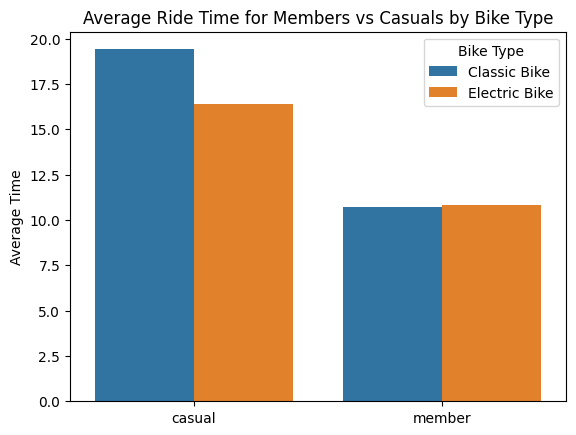

In [127]:
query = f"""
    SELECT member_casual, rideable_type, AVG(ride_time) AS avg_time
    FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type
"""

df = client.query(query).to_dataframe()

ax = sns.barplot(data=df, x='member_casual', y='avg_time', hue='rideable_type')

handles, _ = ax.get_legend_handles_labels()

plt.title('Average Ride Time for Members vs Casuals by Bike Type')
plt.xlabel('')
plt.ylabel('Average Time')
plt.legend(title='Bike Type', handles=handles, labels=['Classic Bike', 'Electric Bike'])
plt.show()

Although members do not have any difference by bike type, it shows difference for casuals and also can be a possible feature to predict time.

Check average time based on day of week.

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


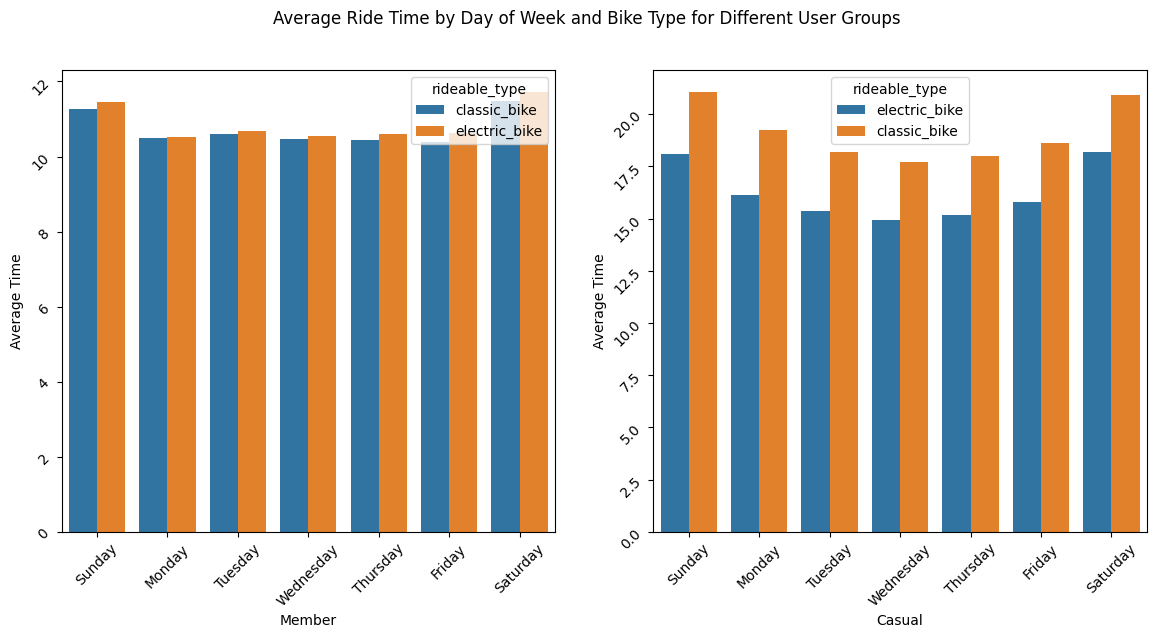

In [151]:
query = f"""
    SELECT 
        member_casual,
        rideable_type,
        day_of_week, 
        AVG(ride_time) as avg_time
        FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type, day_of_week
"""

df = client.query(query).to_dataframe()

custom_dict = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6} 
df = df.sort_values(by='day_of_week', key=lambda x: x.map(custom_dict))

member_df = df[df['member_casual'] == 'member']
casual_df = df[df['member_casual'] == 'casual']

fig, ax = plt.subplots(1,2, figsize=(14, 6), sharex=True)

bar1 = sns.barplot(data=member_df, x='day_of_week', y='avg_time', hue='rideable_type', ax=ax[0])
bar2 = sns.barplot(data=casual_df, x='day_of_week', y='avg_time', hue='rideable_type', ax=ax[1])

labels = ['Classic Bike', 'Electric Bike']
handles, _ = bar1.get_legend_handles_labels()

ax[0].tick_params(labelrotation=45)
# ax[0].get_legend().remove()
ax[0].set_xlabel('Member')
ax[0].set_ylabel('Average Time')

ax[1].tick_params(labelrotation=45)
# ax[1].get_legend().remove()
ax[1].set_xlabel('Casual')
ax[1].set_ylabel('Average Time')

# fig.legend(title='Bike Type', handles=handles, labels=labels, loc='upper right')

plt.suptitle('Average Ride Time by Day of Week and Bike Type for Different User Groups')
plt.show()

Members and casuals show different patterns of usage during the week. Members tend to ride longer on weekends and have around same time for each workday, while casual average time decreases by mid week and then start to increase.

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


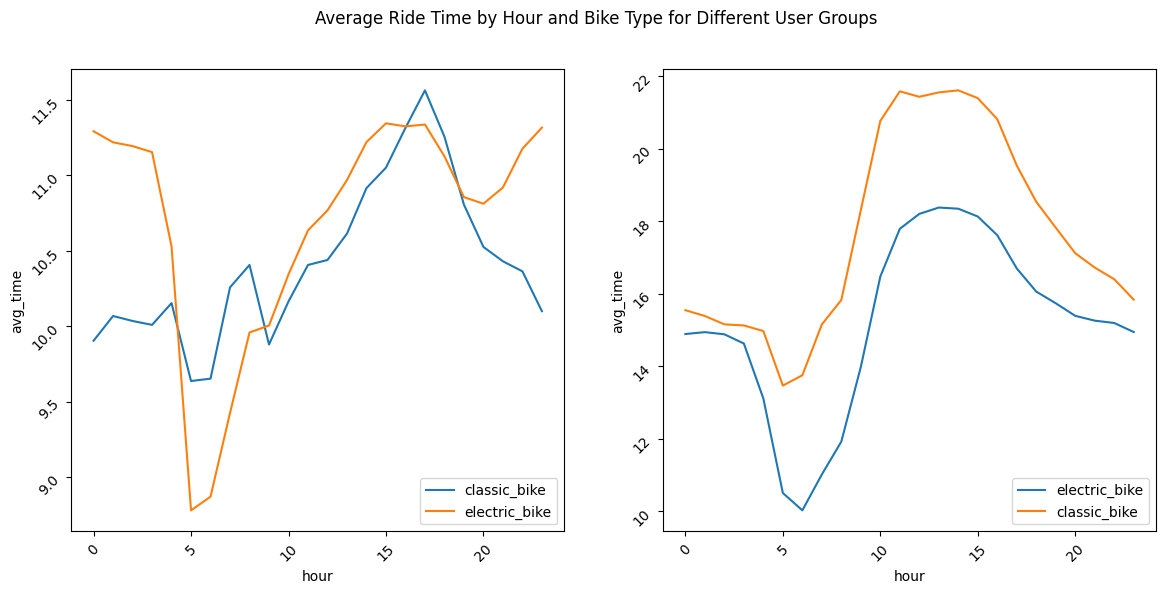

In [13]:
query = f"""
    SELECT 
        member_casual,
        rideable_type,
        EXTRACT(HOUR FROM started_at) as hour, 
        AVG(ride_time) as avg_time
        FROM {cleaned_table_ref}
    GROUP BY member_casual, rideable_type, hour
"""

df = client.query(query).to_dataframe()
df = df.sort_values(by='hour')

member_df = df[df['member_casual'] == 'member']
casual_df = df[df['member_casual'] == 'casual']

fig, ax = plt.subplots(1,2, figsize=(14, 6))

sns.lineplot(data=member_df, x='hour', y='avg_time', hue='rideable_type', ax=ax[0])
sns.lineplot(data=casual_df, x='hour', y='avg_time', hue='rideable_type', ax=ax[1])

ax[0].tick_params(labelrotation=45)
ax[0].legend(loc='lower right')

ax[1].tick_params(labelrotation=45)
ax[1].legend(loc='lower right')

plt.suptitle('Average Ride Time by Hour and Bike Type for Different User Groups')
plt.show()

Now check the statistic of ride time for each group by top 30 most popular start stations.

In [64]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'member' AND rideable_type = 'classic_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,10.15359,1.826929,6.749079,8.95196,9.840749,11.056347,16.022707


In [65]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'member' AND rideable_type = 'electric_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,10.18919,0.935718,8.602719,9.460114,10.175118,10.665352,12.348579


In [66]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'classic_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,25.201538,5.790258,15.86233,20.678327,23.946339,28.727772,37.169646


In [67]:
query = f"""
    SELECT start_station_name, AVG(ride_time) as avg_ride
    FROM {cleaned_table_ref}
    WHERE member_casual = 'casual' AND rideable_type = 'electric_bike'
    GROUP BY start_station_name
    ORDER BY COUNT(*) DESC
    LIMIT 30
"""

df = client.query(query).to_dataframe()
df.describe().T

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
avg_ride,30.0,21.156136,7.073381,12.638243,15.888681,17.58485,27.241334,35.524039


## Hypothesis Testing

In [13]:
query = f"""
    SELECT 
        CASE WHEN start_station_name = end_station_name THEN 'round' ELSE 'one-way' END AS trip_type,
        AVG(ride_time) as avg_time,
        COUNT(*) as cnt
    FROM {cleaned_table_ref}
    GROUP BY trip_type
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_type,avg_time,cnt
0,one-way,11.724088,56357076
1,round,22.614918,1084249


In [5]:
query = f"""
    WITH ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY member_casual, rideable_type ORDER BY ride_id) AS rn
        FROM {cleaned_table_ref}
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 5000
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [6]:
formula = 'ride_time ~ C(member_casual) + C(rideable_type) + C(member_casual):C(rideable_type)'
model = ols(formula, df).fit()
results = sm.stats.anova_lm(model, type=2)
results

,df,sum_sq,mean_sq,F,PR(>F)
C(member_casual),1.0,2.660924e+05,266092.42005,1594.752542,0.000000e+00
C(rideable_type),1.0,8.490348e+03,8490.34805,50.884592,1.013046e-12
C(member_casual):C(rideable_type),1.0,1.273448e+04,12734.48405,76.320666,2.598074e-18
Residual,19996.0,3.336432e+06,166.85499,NaN,NaN


In [ ]:
query = f"""
    WITH ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY day_of_week ORDER BY ride_id) AS rn
        FROM {cleaned_table_ref}
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 15000
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
day_groups = [group['ride_time'].values for _, group in df.groupby('day_of_week')]

f_stat, p_val = f_oneway(*day_groups)

print("F =", f_stat, ", p =", p_val)

Member users: F = 100.66783836554634 , p = 7.486481436879072e-127


In [77]:
query = f"""
    WITH ranked AS (
        SELECT *, 
            ROW_NUMBER() OVER (PARTITION BY EXTRACT(HOUR FROM started_at) ORDER BY RAND()) as rn,
            EXTRACT(HOUR FROM started_at) AS hour
        FROM {cleaned_table_ref}
    )

    SELECT *
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [78]:
day_groups = [group['ride_time'].values for _, group in df.groupby('hour')]

f_stat, p_val = f_oneway(*day_groups)

print("F =", f_stat, ", p =", p_val)

F = 4.695992477183007 , p = 6.629793025812667e-13


In [79]:
query = f"""
    WITH top_30_stations AS (
        SELECT start_station_name
        FROM {cleaned_table_ref}
        GROUP BY start_station_name
        ORDER BY COUNT(*) DESC
        LIMIT 30
    ),

    ranked AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY c.start_station_name ORDER BY RAND()) as rn
        FROM {cleaned_table_ref} c
        WHERE c.start_station_name IN (SELECT start_station_name FROM top_30_stations)
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [82]:
day_groups = [group['ride_time'].values for _, group in df.groupby('start_station_name')]

f_stat, p_val = f_oneway(*day_groups)

print("F =", f_stat, ", p =", p_val)

F = 59.43272973021563 , p = 0.0


In [ ]:
query = f"""
    SELECT 
        ride_time,
        start_station_name,
        EXTRACT(HOUR FROM started_at) as start_hour,
        day_of_week,
        member_casual,
        rideable_type,
    FROM {cleaned_table_ref}
    LIMIT 1000000
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
x = df.drop(columns=['ride_time'])
y = df['ride_time']

label_encoder = LabelEncoder()
X_categorical = x.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
X_numerical = x.select_dtypes(exclude=['object'])

X = pd.concat([pd.DataFrame(X_numerical), X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

RMSE: 139.59 seconds
R² Score: 0.03


In [48]:
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

with open('./weather_nyc.csv', 'rb') as weather_file:
    load_job = client.load_table_from_file(
        weather_file,
        weather_table_ref,
        job_config=job_config
    )
    
load_job.result()

LoadJob<project=nyc-transportation-462009, location=EU, id=ad0b6b33-fc99-4a1b-aca6-8619a70feb8c>

In [4]:
query = f"""
    SELECT * FROM {weather_table_ref}
    LIMIT 5
"""

df = client.query(query).to_dataframe()
df

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1704067200,2024-01-01 00:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.61,10000,-2.18,2.29,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
1,1704070800,2024-01-01 01:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.70,10000,-1.90,2.95,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
2,1704074400,2024-01-01 02:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.54,10000,-1.41,2.20,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
3,1704078000,2024-01-01 03:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.71,10000,-1.07,2.96,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,1704081600,2024-01-01 04:00:00 +0000 UTC,-18000,New York,40.712775,-74.005973,5.65,10000,-0.93,2.89,...,0.0,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [6]:
df.columns

Index(['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [14]:
query = f"""
    CREATE OR REPLACE VIEW {cleaned_weather_table_ref} AS
        SELECT
        *,
        TIMESTAMP(REPLACE(dt_iso, ' +0000 UTC', '')) AS dt_iso_ts
        FROM {weather_table_ref}
"""

job = client.query(query)
job.result()

In [63]:
query = f"""

    WITH weather_type_ride AS (
        SELECT 
            weather.weather_main,
            trips.ride_time
        FROM {cleaned_table_ref} AS trips
        LEFT JOIN {cleaned_weather_table_ref} AS weather
        ON CAST(DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) AS STRING) =
            CAST(DATETIME_TRUNC(DATETIME(TIMESTAMP(weather.dt_iso_ts), 'America/New_York'), HOUR) AS STRING)
    ),

    ranked AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY weather_main ORDER BY RAND()) as rn,
        FROM weather_type_ride
    )

    SELECT * 
    FROM ranked
    WHERE rn <= 500
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [64]:
weather_groups = [group['ride_time'].values for _, group in df.groupby('weather_main')]

f_stat, p_val = f_oneway(*weather_groups)

print("F =", f_stat, ", p =", p_val)

F = 5.697855929708082 , p = 3.1127861759242917e-07


In [ ]:
query = f"""
    SELECT
        trips.ride_time,
        weather.wind_speed,
        weather.temp,
        weather.humidity,
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE 
        trips.ride_time IS NOT NULL
        AND weather.wind_speed IS NOT NULL
    LIMIT 1000000
"""

df = client.query(query).to_dataframe()
df.corr()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [58]:
query = f"""
    SELECT
        trips.ride_time,
        weather.rain_1h
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE 
        trips.ride_time IS NOT NULL
        AND weather.rain_1h IS NOT NULL
    LIMIT 500000
"""

df = client.query(query).to_dataframe()
df.corr()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_time,rain_1h
ride_time,1.000000,-0.016836
rain_1h,-0.016836,1.000000


In [59]:
query = f"""
    SELECT
        trips.ride_time,
        weather.snow_1h,
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE 
        trips.ride_time IS NOT NULL
        AND weather.snow_1h IS NOT NULL
    LIMIT 5000
"""

df = client.query(query).to_dataframe()
df.corr()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,ride_time,snow_1h
ride_time,1.000000,-0.017444
snow_1h,-0.017444,1.000000


In [70]:
query = f"""
    SELECT
        trips.ride_time,
        weather.temp,
        weather.weather_main,
        trips.start_station_name,
        EXTRACT(HOUR FROM trips.started_at) as start_hour,
        trips.day_of_week,
        trips.member_casual,
        trips.rideable_type
    FROM
        {cleaned_table_ref} AS trips
    LEFT JOIN
        {cleaned_weather_table_ref} AS weather
    ON DATETIME_TRUNC(DATETIME(trips.started_at), HOUR) =
        DATETIME_TRUNC(DATETIME(weather.dt_iso_ts, 'America/New_York'), HOUR)
    WHERE 
        trips.ride_time IS NOT NULL
        AND weather.temp IS NOT NULL
        AND weather.weather_main IS NOT NULL
    LIMIT 1000000
"""

df = client.query(query).to_dataframe()

/home/olshe/pers/eu-climate-economic-resilience/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_time           1000000 non-null  float64
 1   temp                1000000 non-null  float64
 2   weather_main        1000000 non-null  object 
 3   start_station_name  1000000 non-null  object 
 4   start_hour          1000000 non-null  Int64  
 5   day_of_week         1000000 non-null  object 
 6   member_casual       1000000 non-null  object 
 7   rideable_type       1000000 non-null  object 
dtypes: Int64(1), float64(2), object(5)
memory usage: 62.0+ MB


In [72]:
x = df.drop(columns=['ride_time'])
y = df['ride_time']

label_encoder = LabelEncoder()
X_categorical = x.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
X_numerical = x.select_dtypes(exclude=['object'])

X = pd.concat([pd.DataFrame(X_numerical), X_categorical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

MSE: 200.13
R² Score: 0.14
